In [1]:
from astropy.io import fits 
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
data = fits.open("/home/andresgo/Documents/Solar Astrophysics/Homework 2/6300_synth.fits")

In [3]:
data.info()

Filename: /home/andresgo/Documents/Solar Astrophysics/Homework 2/6300_synth.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (131, 4, 288, 288)   float64   
  1                1 ImageHDU         6   (131,)   float64   


In [4]:
stokes0 = data[0].data
ll = data[1].data
print(ll)

[6300.7  6300.72 6300.74 6300.76 6300.78 6300.8  6300.82 6300.84 6300.86
 6300.88 6300.9  6300.92 6300.94 6300.96 6300.98 6301.   6301.02 6301.04
 6301.06 6301.08 6301.1  6301.12 6301.14 6301.16 6301.18 6301.2  6301.22
 6301.24 6301.26 6301.28 6301.3  6301.32 6301.34 6301.36 6301.38 6301.4
 6301.42 6301.44 6301.46 6301.48 6301.5  6301.52 6301.54 6301.56 6301.58
 6301.6  6301.62 6301.64 6301.66 6301.68 6301.7  6301.72 6301.74 6301.76
 6301.78 6301.8  6301.82 6301.84 6301.86 6301.88 6301.9  6301.92 6301.94
 6301.96 6301.98 6302.   6302.02 6302.04 6302.06 6302.08 6302.1  6302.12
 6302.14 6302.16 6302.18 6302.2  6302.22 6302.24 6302.26 6302.28 6302.3
 6302.32 6302.34 6302.36 6302.38 6302.4  6302.42 6302.44 6302.46 6302.48
 6302.5  6302.52 6302.54 6302.56 6302.58 6302.6  6302.62 6302.64 6302.66
 6302.68 6302.7  6302.72 6302.74 6302.76 6302.78 6302.8  6302.82 6302.84
 6302.86 6302.88 6302.9  6302.92 6302.94 6302.96 6302.98 6303.   6303.02
 6303.04 6303.06 6303.08 6303.1  6303.12 6303.14 6303

In [5]:
x_coordinate = 18
y_coordinate = 202

stokes0[x_coordinate,y_coordinate,1] = 0
stokes0[x_coordinate,y_coordinate,2] = 0
stokes0[x_coordinate,y_coordinate,3] = 0

In [6]:
# Telescope / observing specifications:
D = 4E2 # Diameter in cm 
t = 1 # Exposure in s 
dlambda = (ll[1]-ll[0])*1E-8 # Lambda bin in cm 
au = 150E11 # 1 AU in cm 
a = 20E5 # Pixel size "on the sun" in cm 
pi = np.pi # 3.14, we will use this often 
deltaE = 6.626E-27 * 2.997E10/6300.E-8 # Energy of the photon 
conversion = a**2.0 * (D/2.)**2.0 * pi / au ** 2.0 * dlambda * 1 / deltaE 
print(conversion)

1.4174890342993653e-07


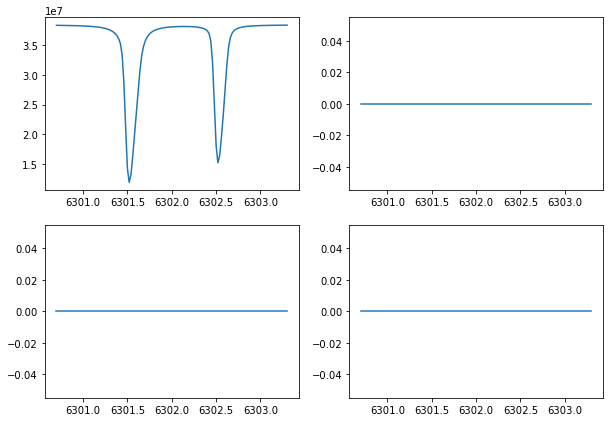

In [7]:
stokes = stokes0 * conversion
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,stokes[x_coordinate,y_coordinate,0])
plt.subplot(222)
plt.plot(ll,stokes[x_coordinate,y_coordinate,1]/stokes[x_coordinate,y_coordinate,0])
plt.subplot(223)
plt.plot(ll,stokes[x_coordinate,y_coordinate,2]/stokes[x_coordinate,y_coordinate,0])
plt.subplot(224)
plt.plot(ll,stokes[x_coordinate,y_coordinate,3]/stokes[x_coordinate,y_coordinate,0])

In [8]:
def modulation_row(theta,delta):
    row = np.zeros(4)
    row[0] = 1.0
    row[1] = np.cos(2.*theta)
    row[2] = np.cos(delta)*np.sin(2.*theta)
    row[3] = np.sin(delta)*np.sin(2.*theta)
    row = row.reshape(1,4)
    return row 

In [9]:
#Let's make our first modulation matrix with four measurements
O4 = modulation_row(0,0)
O4 = np.concatenate([O4,modulation_row(pi/2,0)],axis=0)
O4 = np.concatenate([O4,modulation_row(pi/4,0)],axis=0)
O4 = np.concatenate([O4,modulation_row(pi/4,pi/2)],axis=0)
print (O4)

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00 -1.0000000e+00  1.2246468e-16  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  6.1232340e-17  1.0000000e+00]]


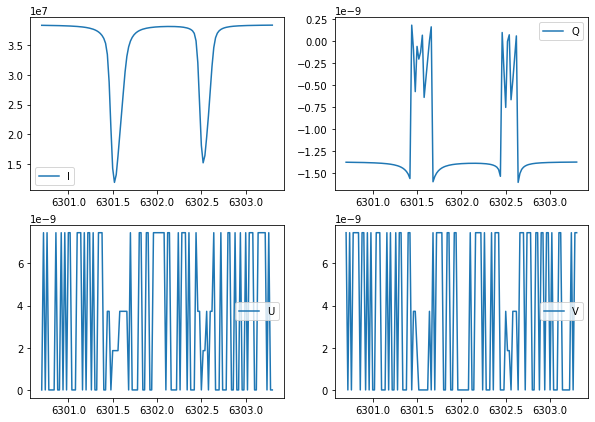

In [10]:
# Modulation
I_original = stokes[x_coordinate,y_coordinate]
nl = len(ll)
S_measured = np.zeros([4,nl]) 
for l in range(0,nl):
    S_measured[:,l] = np.dot(O4,I_original[:,l])

# Seeing induced polarization by demodulation 
I_inferred = np.zeros([4,nl])
O4_inv = np.linalg.inv(O4)
for l in range(0,nl):
    I_inferred[:,l] = np.dot(O4_inv,S_measured[:,l])
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,I_inferred[0],label='I')
plt.legend()
plt.subplot(222)
plt.plot(ll,I_inferred[1],label='Q')
plt.legend()
plt.subplot(223)
plt.plot(ll,I_inferred[2],label='U')
plt.legend()
plt.subplot(224)
plt.plot(ll,I_inferred[3],label='V')   
plt.legend()
plt.savefig('Problem2_a.png',dpi=300)

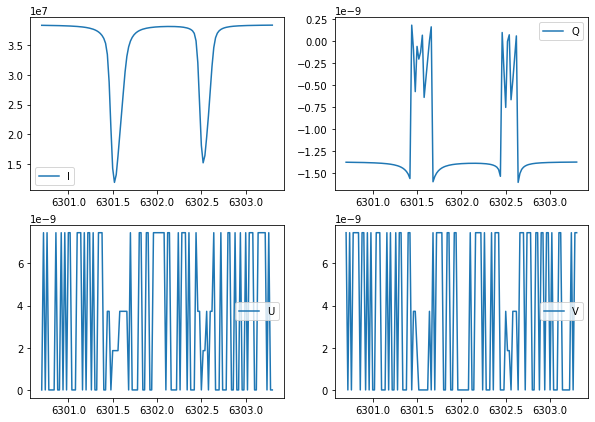

In [11]:
# Let's add some noise now!

I_original = stokes[x_coordinate,y_coordinate]
nl = len(ll)
S_measured = np.zeros([4,nl]) 
for l in range(0,nl):
    S_measured[:,l] = np.dot(O4,I_original[:,l])
    
# Let's add some gaussian noise 
for m in range(0,4):
    for l in range(0,nl):
        S_measured[m,l] += np.random.randn()*np.sqrt(S_measured[m,l]) 

I_inferred4 = np.zeros([4,nl])
O4_inv = np.linalg.inv(O4)
for l in range(0,nl):
    I_inferred4[:,l] = np.dot(O4_inv,S_measured[:,l])
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,I_inferred[0],label='I')
plt.legend()
plt.subplot(222)
plt.plot(ll,I_inferred[1],label='Q')
plt.legend()
plt.subplot(223)
plt.plot(ll,I_inferred[2],label='U')
plt.legend()
plt.subplot(224)
plt.plot(ll,I_inferred[3],label='V')   
plt.legend()

In [12]:
#Let's make our first modulation matrix with six measurements
O6 = modulation_row(0,0)
O6 = np.concatenate([O6,modulation_row(pi/2,0)],axis=0)
O6 = np.concatenate([O6,modulation_row(pi/4,0)],axis=0)
O6 = np.concatenate([O6,modulation_row(3*pi/4,pi/2)],axis=0)
O6 = np.concatenate([O6,modulation_row(pi/4,pi/2)],axis=0)
O6 = np.concatenate([O6,modulation_row(3*pi/4,pi/2)],axis=0)
print (O6)

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00 -1.0000000e+00  1.2246468e-16  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00 -1.8369702e-16 -6.1232340e-17 -1.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  6.1232340e-17  1.0000000e+00]
 [ 1.0000000e+00 -1.8369702e-16 -6.1232340e-17 -1.0000000e+00]]


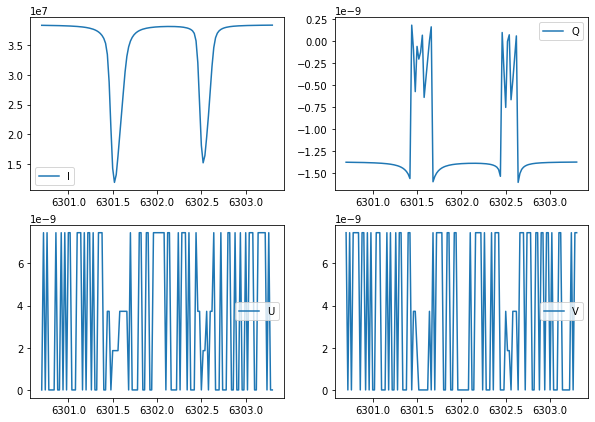

In [13]:
# Modulation 
I_original = stokes[x_coordinate,y_coordinate]
S_measured6 = np.zeros([6,nl]) 
for l in range(0,nl):
    S_measured6[:,l] = np.dot(O6,I_original[:,l])
    
# Seeing induced polarization by demodulation 
I_inferred6 = np.zeros([4,nl])
O6_inv = np.linalg.pinv(O6)
for l in range(0,nl):
    I_inferred6[:,l] = np.dot(O6_inv,S_measured6[:,l])   
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,I_inferred[0],label='I')
plt.legend()
plt.subplot(222)
plt.plot(ll,I_inferred[1],label='Q')
plt.legend()
plt.subplot(223)
plt.plot(ll,I_inferred[2],label='U')
plt.legend()
plt.subplot(224)
plt.plot(ll,I_inferred[3],label='V')   
plt.legend()
plt.savefig('Problem2_b.png',dpi=300)

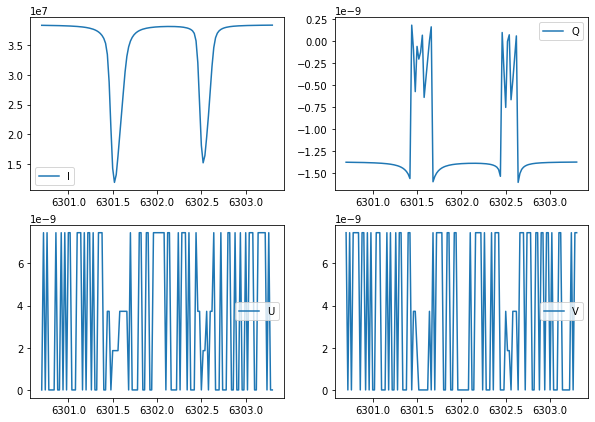

In [14]:
I_original = stokes[x_coordinate,y_coordinate]
S_measured6 = np.zeros([6,nl]) 
for l in range(0,nl):
    S_measured6[:,l] = np.dot(O6,I_original[:,l])

S_measured6 *= 4./6.
#Let's add some gaussian noise
for m in range(0,6):
    for l in range(0,nl):
        S_measured6[m,l] += np.random.randn()*np.sqrt(S_measured6[m,l])

I_inferred6 = np.zeros([4,nl])
O6_inv = np.linalg.pinv(O6)
for l in range(0,nl):
    I_inferred6[:,l] = np.dot(O6_inv,S_measured6[:,l])   
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll,I_inferred[0],label='I')
plt.legend()
plt.subplot(222)
plt.plot(ll,I_inferred[1],label='Q')
plt.legend()
plt.subplot(223)
plt.plot(ll,I_inferred[2],label='U')
plt.legend()
plt.subplot(224)
plt.plot(ll,I_inferred[3],label='V')   
plt.legend()